# Import Libraries

In [4]:
# basic data science stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# tensorflow/keras for modeling
import tensorflow as tf
from tensorflow.keras import models, layers, losses, utils, callbacks, preprocessing, applications

# pickle for saving/loading
import pickle

# Load Data

In [5]:
with open('../Data/Cleaned/X_train.pickle', 'rb') as file:
    X_train = pickle.load(file)

with open('../Data/Cleaned/X_test.pickle', 'rb') as file:
    X_test = pickle.load(file)

with open('../Data/Cleaned/y_train.pickle', 'rb') as file:
    y_train = pickle.load(file)

with open('../Data/Cleaned/y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14034, 150, 150, 3) (14034,) (3000, 150, 150, 3) (3000,)


# Helper Functions

In [22]:
def accuracy_line_plot(history, metric, validation_metric):
    """Create line plot comparing metrics for the training and validation sets over each epoch"""
    
    plt.plot(history.history[metric], label=metric)
    plt.plot(history.history[validation_metric], label = validation_metric)
    plt.title("Training and Testing Accuracy per Epoch")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    
def load_evaluate_model(model_name, X, y, class_labels):
    """Load a model, evaluate accuracy, make predictions, create classification report, 
    and create confusion matrix heatmap"""
    
    # Load Model
    path = '../Models/' + model_name
    model = models.load_model(path)
    
    # Evaluate accuracy
    loss, acc = model.evaluate(X, y)
    print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
    
    # Make Predictions and create classification report
    y_pred = np.argmax(model.predict(X), axis = -1)
    print(classification_report(y, y_pred))
    
    # Create confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    # Create heatmap of confusion matrix
    sns.set_context('poster')
    fig, ax = plt.subplots(figsize = (15,10))
    sns.heatmap(cm, annot=True, fmt='.0f', ax = ax)
    ax.set_title('Predicted vs True Classes for {}'.format(model_name))
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticklabels(labels=class_labels, rotation = 45)
    ax.set_yticklabels(labels=class_labels, rotation = 45)
    plt.tight_layout()
    plt.show() 
    
    
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Purpose of Transfer Learning

With the help of image augmentation we were able to improve our basic convolutional model from 79.8% all the way to 87.5% accuracy on the validation data. By experimenting with adding additional layers, or adjusting our current convolution/pooling layers we may be able to squeak out another percentage point or two from our model, but there is a more efficient way to improve performance.

Transfer learning allows us to utilize the thousands of hours of training that major research teams have done to tune their models on famous datasets like the ImageNet database (which contains millions of images that belong to around 1000 different classes), and then apply what those models have learned to our specific problem. 

Even though we might not be trying to predict the exact same classes as the research models were, many of the features identified by the models are useful across almost all image classification tasks.

I will be testing three different models: Xception, ResNet50 and DenseNet.

# Xception

In [11]:
# Instantiate an Xception model class
base_model = applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation='softmax')(x)

xception_v1 = tf.keras.Model(inputs, outputs)

In [12]:
xception_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

xception_v1.fit(
    X_train, 
    y_train, 
    epochs=20, 
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/20
439/439 - 37s - loss: 0.4191 - acc: 0.8502 - val_loss: 0.3287 - val_acc: 0.8787
Epoch 2/20
439/439 - 28s - loss: 0.3030 - acc: 0.8916 - val_loss: 0.3175 - val_acc: 0.8837
Epoch 3/20
439/439 - 28s - loss: 0.2714 - acc: 0.9022 - val_loss: 0.3192 - val_acc: 0.8827
Epoch 4/20
439/439 - 28s - loss: 0.2477 - acc: 0.9092 - val_loss: 0.3176 - val_acc: 0.8810
Epoch 5/20
439/439 - 29s - loss: 0.2296 - acc: 0.9173 - val_loss: 0.3074 - val_acc: 0.8830
Epoch 6/20
439/439 - 28s - loss: 0.2156 - acc: 0.9216 - val_loss: 0.3121 - val_acc: 0.8830
Epoch 7/20
439/439 - 28s - loss: 0.2054 - acc: 0.9267 - val_loss: 0.3020 - val_acc: 0.8920
Epoch 8/20
439/439 - 29s - loss: 0.1971 - acc: 0.9288 - val_loss: 0.3202 - val_acc: 0.8877
Epoch 9/20
439/439 - 29s - loss: 0.1857 - acc: 0.9330 - val_loss: 0.3145 - val_acc: 0.8853
Epoch 10/20
439/439 - 29s - loss: 0.1779 - acc: 0.9379 - val_loss: 0.3366 - val_acc: 0.8727
Epoch 11/20
439/439 - 29s - loss: 0.1741 - acc: 0.9369 - val_loss: 0.3191 - val_acc: 0.88

In [18]:
xception_v1.save('../Models/xception_v1')

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/xception_v1\assets


# xception_v1 Evaluation
# 20 epochs, NO image augmentation

94/94 [==============================] - 6s 53ms/step - loss: 0.3546 - acc: 0.8810
Restored model, accuracy: 88.10%
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       437
           1       0.97      0.98      0.98       474
           2       0.82      0.83      0.82       553
           3       0.82      0.79      0.81       525
           4       0.92      0.93      0.92       510
           5       0.87      0.91      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



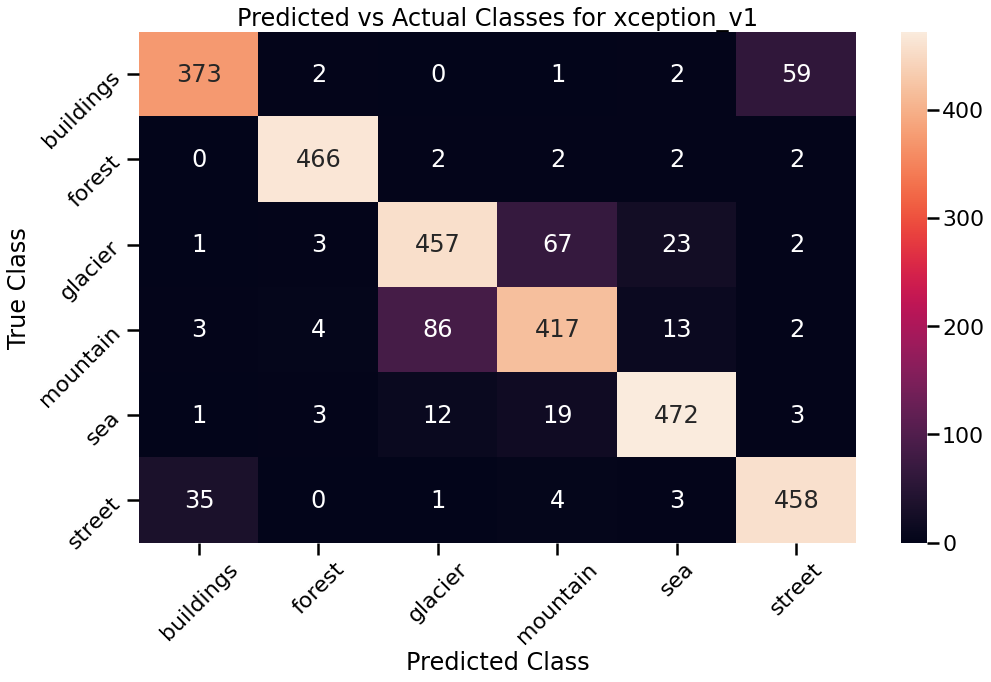

In [13]:
load_evaluate_model('xception_v1', X_test, y_test, labels)

# Xception with Image Augmentation

In [23]:
# Instantiate an Xception model class
base_model = applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation='softmax')(x)

xception_v2 = tf.keras.Model(inputs, outputs)

In [24]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4  
)

datagen.fit(X_train)

xception_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

xception_v2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20, 
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/20
439/439 - 54s - loss: 0.5592 - acc: 0.7938 - val_loss: 0.3663 - val_acc: 0.8613
Epoch 2/20
439/439 - 52s - loss: 0.4330 - acc: 0.8371 - val_loss: 0.3417 - val_acc: 0.8730
Epoch 3/20
439/439 - 53s - loss: 0.4085 - acc: 0.8504 - val_loss: 0.3319 - val_acc: 0.8760
Epoch 4/20
439/439 - 52s - loss: 0.3977 - acc: 0.8497 - val_loss: 0.3465 - val_acc: 0.8733
Epoch 5/20
439/439 - 53s - loss: 0.3750 - acc: 0.8649 - val_loss: 0.3292 - val_acc: 0.8757
Epoch 6/20
439/439 - 53s - loss: 0.3809 - acc: 0.8575 - val_loss: 0.3334 - val_acc: 0.8817
Epoch 7/20
439/439 - 53s - loss: 0.3674 - acc: 0.8639 - val_loss: 0.3344 - val_acc: 0.8750
Epoch 8/20
439/439 - 53s - loss: 0.3636 - acc: 0.8663 - val_loss: 0.3217 - val_acc: 0.8837
Epoch 9/20
439/439 - 53s - loss: 0.3673 - acc: 0.8633 - val_loss: 0.3417 - val_acc: 0.8767
Epoch 10/20
439/439 - 53s - loss: 0.3690 - acc: 0.8645 - val_loss: 0.3247 - val_acc: 0.8820
Epoch 11/20
439/439 - 53s - loss: 0.3524 - acc: 0.8690 - val_loss: 0.3265 - val_acc: 0.87

In [25]:
xception_v2.save('../Models/xception_v2')

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/xception_v2\assets


# xception_v2 Evaluation 
# 20 epochs, With image augmentation, NO channel shift

94/94 [==============================] - 6s 53ms/step - loss: 0.3262 - acc: 0.8860
Restored model, accuracy: 88.60%
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       437
           1       0.98      0.99      0.98       474
           2       0.81      0.83      0.82       553
           3       0.82      0.79      0.81       525
           4       0.93      0.92      0.92       510
           5       0.86      0.96      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



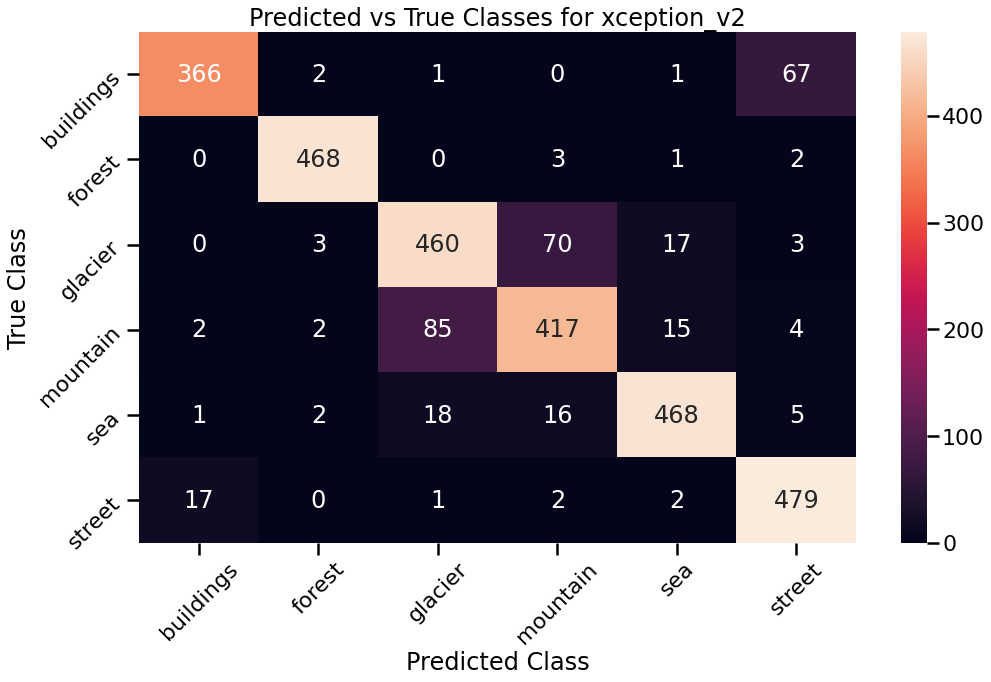

In [16]:
load_evaluate_model('xception_v2', X_test, y_test, labels)

# Xception with Image Augmentation including Channel Shift

In [27]:
# Instantiate an Xception model class
base_model = applications.Xception(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation='softmax')(x)

xception_v3 = tf.keras.Model(inputs, outputs)

In [28]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4,
    channel_shift_range=0.4
)

datagen.fit(X_train)

xception_v3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

xception_v3.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20, 
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/20
439/439 - 69s - loss: 0.5891 - acc: 0.7854 - val_loss: 0.3690 - val_acc: 0.8643
Epoch 2/20
439/439 - 67s - loss: 0.4693 - acc: 0.8292 - val_loss: 0.3528 - val_acc: 0.8687
Epoch 3/20
439/439 - 67s - loss: 0.4480 - acc: 0.8363 - val_loss: 0.3851 - val_acc: 0.8573
Epoch 4/20
439/439 - 67s - loss: 0.4263 - acc: 0.8427 - val_loss: 0.3243 - val_acc: 0.8820
Epoch 5/20
439/439 - 68s - loss: 0.4207 - acc: 0.8456 - val_loss: 0.3499 - val_acc: 0.8663
Epoch 6/20
439/439 - 68s - loss: 0.4264 - acc: 0.8444 - val_loss: 0.3442 - val_acc: 0.8717
Epoch 7/20
439/439 - 68s - loss: 0.4051 - acc: 0.8532 - val_loss: 0.3538 - val_acc: 0.8710
Epoch 8/20
439/439 - 67s - loss: 0.4036 - acc: 0.8544 - val_loss: 0.3298 - val_acc: 0.8797
Epoch 9/20
439/439 - 67s - loss: 0.3997 - acc: 0.8550 - val_loss: 0.3278 - val_acc: 0.8770
Epoch 10/20
439/439 - 67s - loss: 0.3976 - acc: 0.8531 - val_loss: 0.3278 - val_acc: 0.8803
Epoch 11/20
439/439 - 68s - loss: 0.3964 - acc: 0.8539 - val_loss: 0.3310 - val_acc: 0.87

In [29]:
xception_v3.save('../Models/xception_v3')

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/xception_v3\assets


# xception_v3 Evaluation 
# 20 epochs, with image augmentation, INCLUDING channel shift

94/94 [==============================] - 6s 53ms/step - loss: 0.3296 - acc: 0.8820
Restored model, accuracy: 88.20%
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       437
           1       0.97      0.98      0.98       474
           2       0.80      0.84      0.82       553
           3       0.83      0.77      0.80       525
           4       0.92      0.93      0.92       510
           5       0.85      0.96      0.90       501

    accuracy                           0.88      3000
   macro avg       0.89      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



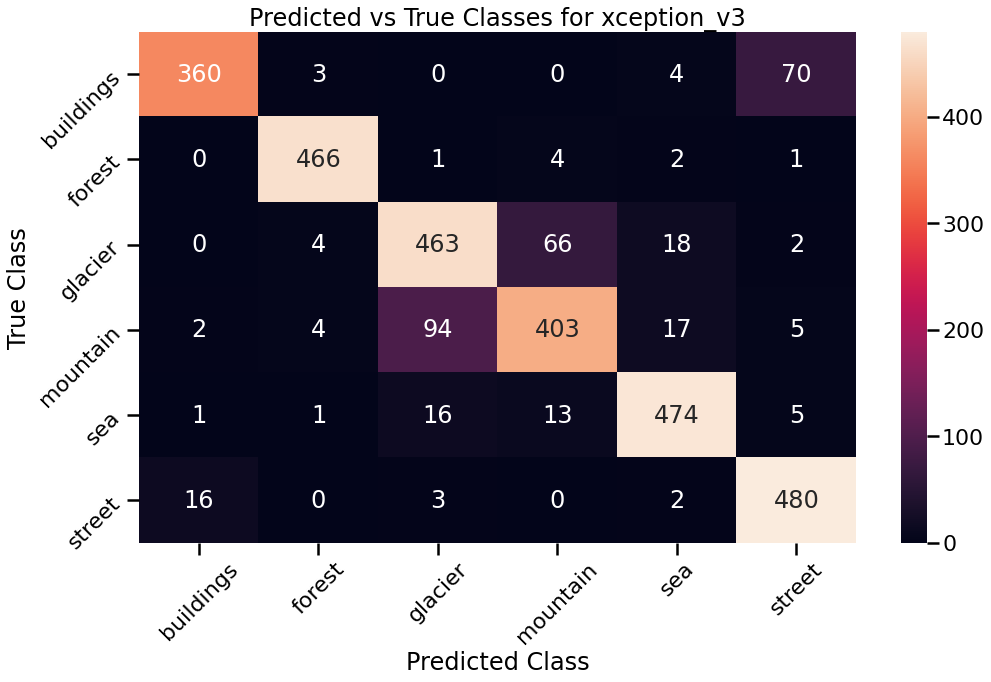

In [17]:
load_evaluate_model('xception_v3', X_test, y_test, labels)

# ResNet50 with Image Augmentation

In [34]:
# Instantiate a resnet model class
base_model = applications.ResNet50V2(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation='softmax')(x)

resnet_v1 = tf.keras.Model(inputs, outputs)

In [35]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4
)

datagen.fit(X_train)

resnet_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

resnet_v1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20, 
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/20
439/439 - 63s - loss: 0.5228 - acc: 0.8107 - val_loss: 0.3200 - val_acc: 0.8863
Epoch 2/20
439/439 - 53s - loss: 0.3870 - acc: 0.8572 - val_loss: 0.2953 - val_acc: 0.8957
Epoch 3/20
439/439 - 54s - loss: 0.3667 - acc: 0.8661 - val_loss: 0.2984 - val_acc: 0.8933
Epoch 4/20
439/439 - 53s - loss: 0.3467 - acc: 0.8762 - val_loss: 0.2929 - val_acc: 0.8980
Epoch 5/20
439/439 - 54s - loss: 0.3460 - acc: 0.8756 - val_loss: 0.3085 - val_acc: 0.8893
Epoch 6/20
439/439 - 54s - loss: 0.3364 - acc: 0.8770 - val_loss: 0.3091 - val_acc: 0.8913
Epoch 7/20
439/439 - 53s - loss: 0.3263 - acc: 0.8816 - val_loss: 0.3101 - val_acc: 0.8930
Epoch 8/20
439/439 - 53s - loss: 0.3260 - acc: 0.8832 - val_loss: 0.2923 - val_acc: 0.8993
Epoch 9/20
439/439 - 54s - loss: 0.3295 - acc: 0.8797 - val_loss: 0.2864 - val_acc: 0.9000
Epoch 10/20
439/439 - 54s - loss: 0.3163 - acc: 0.8834 - val_loss: 0.3132 - val_acc: 0.8920
Epoch 11/20
439/439 - 54s - loss: 0.3321 - acc: 0.8792 - val_loss: 0.2986 - val_acc: 0.89

In [36]:
resnet_v1.save('../Models/resnet_v1')

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/resnet_v1\assets


# resnet_v1 Evaluation 
# 20 epochs, with image augmentation, NO channel shift

94/94 [==============================] - 6s 51ms/step - loss: 0.3077 - acc: 0.8917
Restored model, accuracy: 89.17%
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       437
           1       0.99      0.98      0.98       474
           2       0.85      0.82      0.83       553
           3       0.81      0.82      0.81       525
           4       0.91      0.95      0.93       510
           5       0.90      0.93      0.91       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



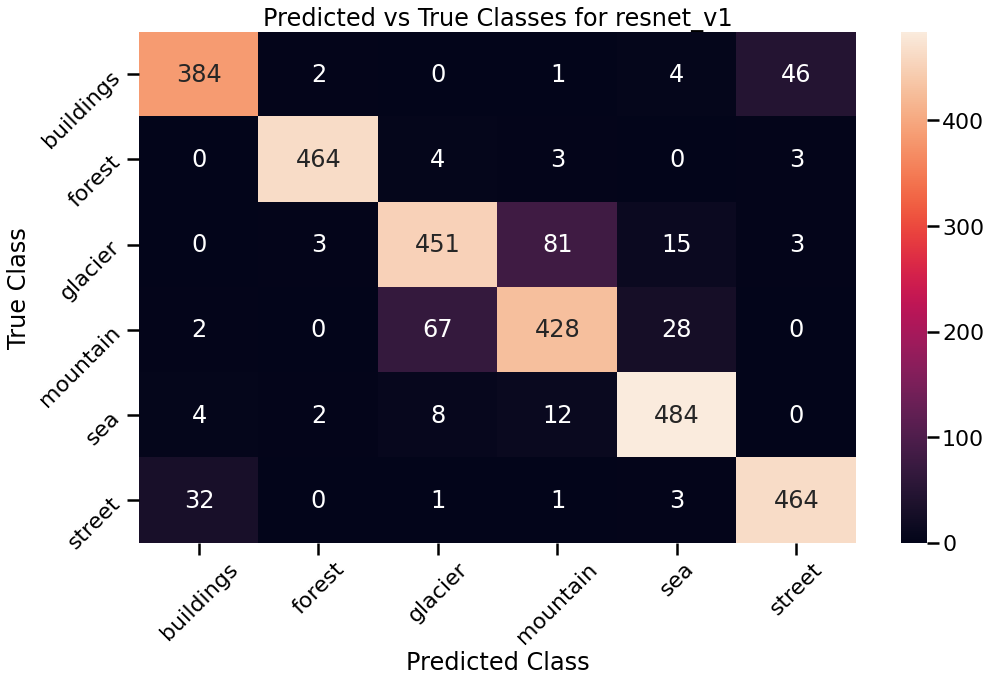

In [18]:
load_evaluate_model('resnet_v1', X_test, y_test, labels)

# DenseNet with Image Augmentation

In [39]:
# Instantiate a DenseNet model class
base_model = applications.DenseNet201(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation = 'softmax')(x)

densenet_v1 = tf.keras.Model(inputs, outputs)

74842112/74836368 [==============================] - 3s 0us/step


In [40]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4
)

datagen.fit(X_train)

densenet_v1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

densenet_v1.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20, 
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/20
439/439 - 71s - loss: 0.5371 - acc: 0.8087 - val_loss: 0.3335 - val_acc: 0.8787
Epoch 2/20
439/439 - 58s - loss: 0.3662 - acc: 0.8690 - val_loss: 0.3017 - val_acc: 0.8887
Epoch 3/20
439/439 - 58s - loss: 0.3450 - acc: 0.8766 - val_loss: 0.3069 - val_acc: 0.8907
Epoch 4/20
439/439 - 58s - loss: 0.3278 - acc: 0.8823 - val_loss: 0.3141 - val_acc: 0.8847
Epoch 5/20
439/439 - 58s - loss: 0.3146 - acc: 0.8843 - val_loss: 0.2957 - val_acc: 0.8900
Epoch 6/20
439/439 - 58s - loss: 0.3128 - acc: 0.8868 - val_loss: 0.2891 - val_acc: 0.8980
Epoch 7/20
439/439 - 58s - loss: 0.3130 - acc: 0.8855 - val_loss: 0.2995 - val_acc: 0.8917
Epoch 8/20
439/439 - 58s - loss: 0.3111 - acc: 0.8871 - val_loss: 0.3044 - val_acc: 0.8900
Epoch 9/20
439/439 - 58s - loss: 0.2961 - acc: 0.8920 - val_loss: 0.3002 - val_acc: 0.8953
Epoch 10/20
439/439 - 58s - loss: 0.2988 - acc: 0.8905 - val_loss: 0.2966 - val_acc: 0.8990
Epoch 11/20
439/439 - 59s - loss: 0.3030 - acc: 0.8906 - val_loss: 0.3144 - val_acc: 0.89

In [41]:
densenet_v1.save('../Models/densenet_v1')

INFO:tensorflow:Assets written to: ../Models/densenet_v1\assets


# densenet_v1 Evaluation 
# 20 epochs, with image augmentation, NO channel shift

94/94 [==============================] - 14s 102ms/step - loss: 0.2995 - acc: 0.8953
Restored model, accuracy: 89.53%
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       437
           1       0.98      0.99      0.98       474
           2       0.87      0.77      0.82       553
           3       0.80      0.87      0.84       525
           4       0.92      0.93      0.93       510
           5       0.92      0.92      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.89      3000



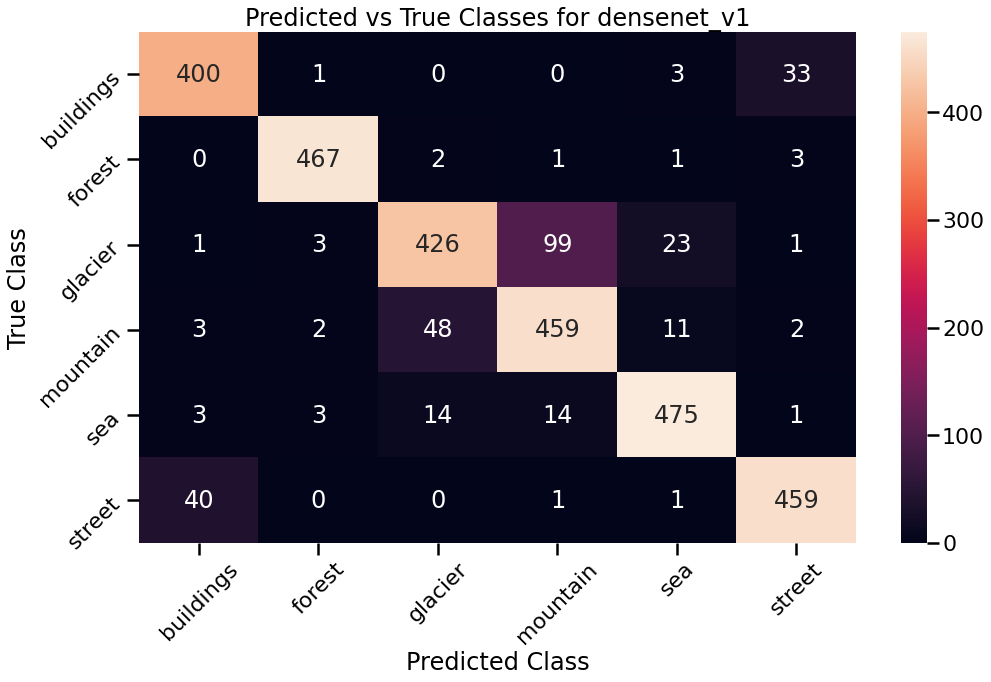

In [19]:
load_evaluate_model('densenet_v1', X_test, y_test, labels)

# 100 Epochs - DenseNet with Image Augmentation

In [18]:
# Instantiate a DenseNet model class
base_model = applications.DenseNet201(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation = 'softmax')(x)

densenet_v2 = tf.keras.Model(inputs, outputs)

In [19]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4
)

datagen.fit(X_train)

densenet_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

checkpoints = callbacks.ModelCheckpoint(
    filepath='../Models/Checkpoints/densenet_v2/{epoch:03d}-{acc:.2f}-{val_acc:.2f}',
    save_weights_only=True,
    monitor='val_acc'
)

stopping = callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 5
)

my_callbacks = [checkpoints, stopping]

densenet_v2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    callbacks=my_callbacks,
    validation_data=(X_test, y_test), 
    verbose=2
)

Epoch 1/100
439/439 - 82s - loss: 0.5122 - acc: 0.8093 - val_loss: 0.3329 - val_acc: 0.8797
Epoch 2/100
439/439 - 71s - loss: 0.3631 - acc: 0.8677 - val_loss: 0.3050 - val_acc: 0.8893
Epoch 3/100
439/439 - 69s - loss: 0.3427 - acc: 0.8742 - val_loss: 0.3465 - val_acc: 0.8763
Epoch 4/100
439/439 - 56s - loss: 0.3279 - acc: 0.8811 - val_loss: 0.3043 - val_acc: 0.8897
Epoch 5/100
439/439 - 57s - loss: 0.3184 - acc: 0.8808 - val_loss: 0.3094 - val_acc: 0.8897
Epoch 6/100
439/439 - 57s - loss: 0.3134 - acc: 0.8893 - val_loss: 0.2881 - val_acc: 0.9000
Epoch 7/100
439/439 - 58s - loss: 0.3120 - acc: 0.8867 - val_loss: 0.2929 - val_acc: 0.8993
Epoch 8/100
439/439 - 56s - loss: 0.2987 - acc: 0.8908 - val_loss: 0.3081 - val_acc: 0.8897
Epoch 9/100
439/439 - 56s - loss: 0.2991 - acc: 0.8918 - val_loss: 0.2910 - val_acc: 0.8987
Epoch 10/100
439/439 - 56s - loss: 0.3009 - acc: 0.8887 - val_loss: 0.3154 - val_acc: 0.8900
Epoch 11/100
439/439 - 56s - loss: 0.2953 - acc: 0.8935 - val_loss: 0.2980 - va

In [20]:
densenet_v2.save('../Models/densenet_v2')

INFO:tensorflow:Assets written to: ../Models/densenet_v2\assets


# densenet_v2 Evaluation
# 100 epochs, with image augmentation, NO channel shift

94/94 [==============================] - 9s 78ms/step - loss: 0.3154 - acc: 0.8963
Restored model, accuracy: 89.63%
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       437
           1       0.98      0.99      0.99       474
           2       0.82      0.86      0.84       553
           3       0.86      0.82      0.84       525
           4       0.93      0.90      0.92       510
           5       0.95      0.87      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



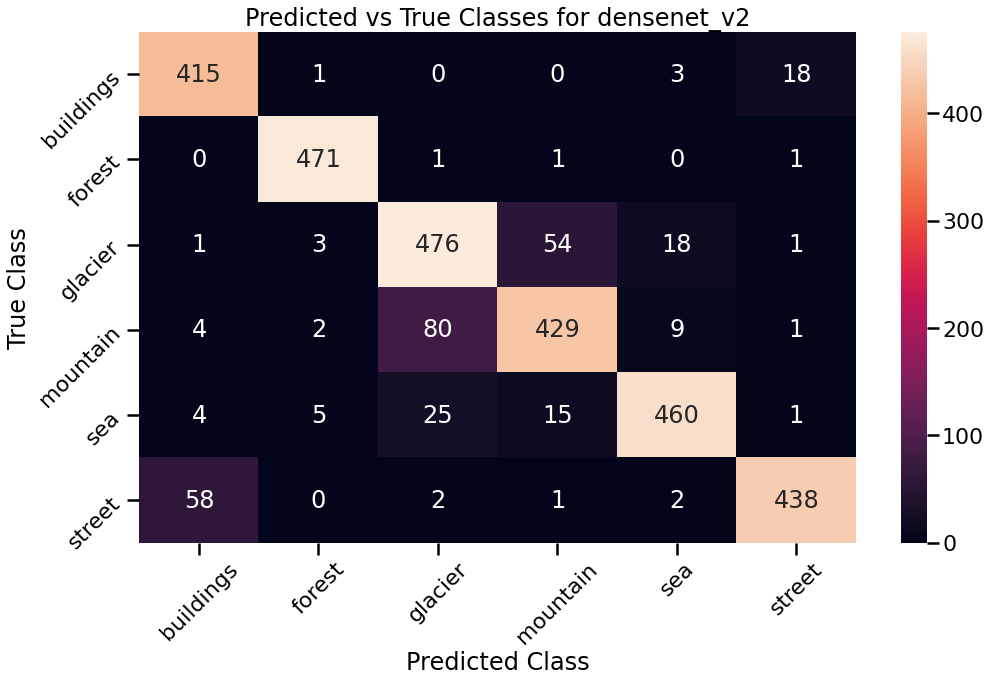

In [20]:
load_evaluate_model('densenet_v2', X_test, y_test, labels)

# 100 Epochs - ResNet with Image Augmentation

In [6]:
# Instantiate a DenseNet model class
base_model = applications.ResNet50V2(
    weights='imagenet',
    input_shape=(150,150,3),
    include_top=False
)

# set trainable to False, since for now we just want to use the features that were already discovered by the model
# when training on the imagenet database
base_model.trainable = False

# Add a new model on top of the pre-trained model, this will allow us to make predictions on our own dataset
inputs = tf.keras.Input(shape=(150, 150, 3))

# Make sure that training = False
x = base_model(inputs, training=False)
# Take feature maps and convert them to vectors
x = layers.GlobalAveragePooling2D()(x)
# put a dense classifier on top that will map the results to our 6 different classes
outputs = layers.Dense(6, activation = 'softmax')(x)

resnet_v2 = tf.keras.Model(inputs, outputs)

In [8]:
datagen = preprocessing.image.ImageDataGenerator(
    width_shift_range=0.4,
    horizontal_flip=True,
    zoom_range=0.4,
    shear_range=0.4
)

datagen.fit(X_train)

resnet_v2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

checkpoints = callbacks.ModelCheckpoint(
    filepath='../Models/Checkpoints/densenet_v2/{epoch:03d}-{acc:.2f}-{val_acc:.2f}',
    save_weights_only=True,
    monitor='val_acc'
)

stopping = callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 10
)

my_callbacks = [checkpoints, stopping]

resnet_v2.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    callbacks=my_callbacks,
    validation_data=(X_test, y_test), 
    verbose=2
)



Epoch 1/100
439/439 - 59s - loss: 0.3215 - acc: 0.8848 - val_loss: 0.2893 - val_acc: 0.8990
Epoch 2/100
439/439 - 51s - loss: 0.3192 - acc: 0.8830 - val_loss: 0.2963 - val_acc: 0.8943
Epoch 3/100
439/439 - 54s - loss: 0.3209 - acc: 0.8834 - val_loss: 0.2990 - val_acc: 0.8953
Epoch 4/100
439/439 - 52s - loss: 0.3157 - acc: 0.8873 - val_loss: 0.3067 - val_acc: 0.8967
Epoch 5/100
439/439 - 52s - loss: 0.3073 - acc: 0.8886 - val_loss: 0.3004 - val_acc: 0.8960
Epoch 6/100
439/439 - 52s - loss: 0.3102 - acc: 0.8874 - val_loss: 0.3030 - val_acc: 0.8933
Epoch 7/100
439/439 - 53s - loss: 0.3047 - acc: 0.8889 - val_loss: 0.3171 - val_acc: 0.8927
Epoch 8/100
439/439 - 52s - loss: 0.3033 - acc: 0.8868 - val_loss: 0.3096 - val_acc: 0.8880
Epoch 9/100
439/439 - 55s - loss: 0.3090 - acc: 0.8878 - val_loss: 0.3011 - val_acc: 0.8987
Epoch 10/100
439/439 - 51s - loss: 0.3173 - acc: 0.8844 - val_loss: 0.3178 - val_acc: 0.8900
Epoch 11/100
439/439 - 50s - loss: 0.3094 - acc: 0.8872 - val_loss: 0.3279 - va

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/resnet_v2\assets


In [13]:
resnet_v2.load_weights(r'..\Models\Checkpoints\resnet_v2\001-0.88-0.90')
resnet_v2.save('../Models/resnet_v2')

C:\Users\atyou\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ../Models/resnet_v2\assets


# resnet_v2 Evaluation
# 100 epochs, with image augmentation, NO channel shift

94/94 [==============================] - 5s 42ms/step - loss: 0.2893 - acc: 0.8990
Restored model, accuracy: 89.90%
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       437
           1       0.99      0.98      0.99       474
           2       0.84      0.84      0.84       553
           3       0.82      0.85      0.84       525
           4       0.94      0.93      0.94       510
           5       0.90      0.92      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



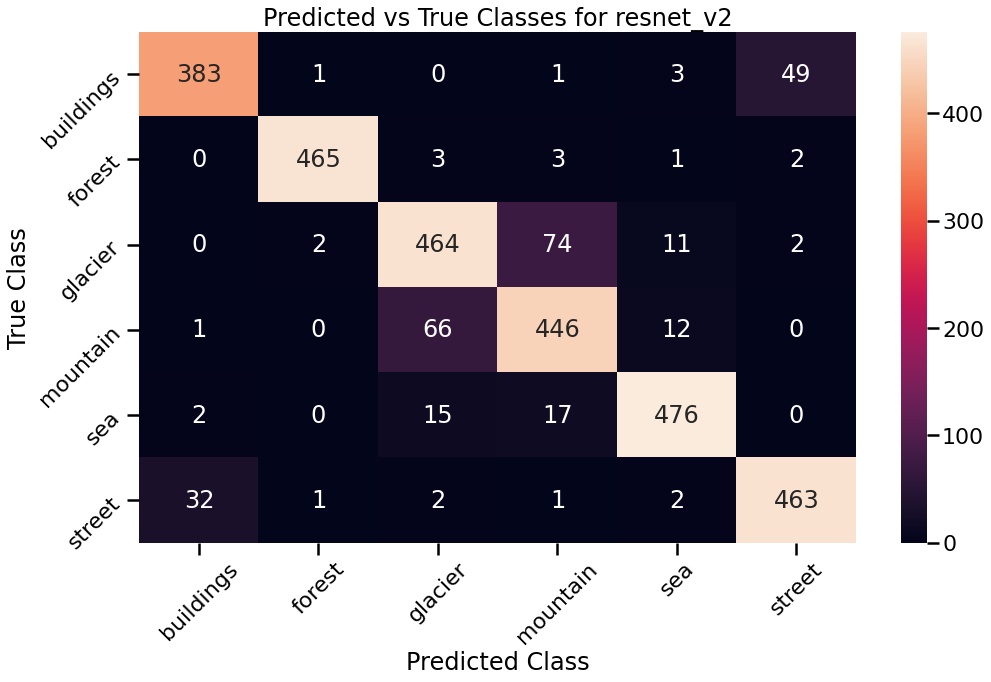

In [21]:
load_evaluate_model('resnet_v2', X_test, y_test, labels)

# Final Model Choice

The final densenet and resnet models offer similar performance. However, I will likely choose the resnet as the final model to implement into my personal website portfolio since it seems to load and make predictions faster than the densenet model.